In [1]:
import torch
import scipy as sc
import numpy as np
from PIL import Image
import os
import re
import torch.nn.functional as F
import cv2
import numpy as np
import time
from scipy.io import loadmat, savemat
import torch.nn as nn
from tensorflow.keras.optimizers import Adam
from torch.autograd import Variable
from torchvision.models import resnet
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torchsummary import summary

import matplotlib.pyplot as plt

In [ ]:
folder_path = os.path.dirname(os.path.dirname(os.getcwd()))
folder_path

In [2]:
torch.cuda.empty_cache()

In [3]:
transform = transforms.ToTensor()

In [4]:
device = torch.device("cuda:0")
torch.set_default_device(device)

#torch.cuda.set_per_process_memory_fraction(0.5, device=device)

print(torch.cuda.get_device_properties(device).multi_processor_count)
torch.cuda.memory_allocated(device=torch.device("cuda"))
torch.cuda.memory_summary(device=torch.device("cuda"), abbreviated=False)

36


'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |\n|       from large pool |      0 B   |      0 B   |      0 B   |      0 B   |\n|       from small pool |      0 B   |      0 B   |      0 B   |      0 B   |\n|---------------------------------------------------------------------------|\n| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |\n|       from large pool |      0 B   |      0 B   |

In [5]:
class BasicBlock(nn.Module):

    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0, groups=1, bias=False, dropout_rate = 0.0):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size, stride, padding, groups=groups, bias=bias)
        self.bn1 = nn.BatchNorm2d(out_planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size, 1, padding, groups=groups, bias=bias)
        self.bn2 = nn.BatchNorm2d(out_planes)
        self.dropout = nn.Dropout2d(dropout_rate)
        self.downsample = None
        if stride > 1:
            self.downsample = nn.Sequential(nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False),
                            nn.BatchNorm2d(out_planes),)

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)
        out = self.dropout(out)
        return out

In [6]:
class Encoder(nn.Module):

    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0, groups=1, bias=False, dropout_rate = 0):
        super(Encoder, self).__init__()
        self.block1 = BasicBlock(in_planes, out_planes, kernel_size, stride, padding, groups, bias, dropout_rate)
        self.block2 = BasicBlock(out_planes, out_planes, kernel_size, 1, padding, groups, bias, dropout_rate)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)

        return x

In [7]:
class Decoder(nn.Module):

    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0, output_padding=0, groups=1, bias=False):
        # TODO bias=True
        super(Decoder, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(in_planes, in_planes//4, 1, 1, 0, bias=bias),
                                nn.BatchNorm2d(in_planes//4),
                                nn.ReLU(inplace=True),)
        self.tp_conv = nn.Sequential(nn.ConvTranspose2d(in_planes//4, in_planes//4, kernel_size, stride, padding, output_padding, bias=bias),
                                nn.BatchNorm2d(in_planes//4),
                                nn.ReLU(inplace=True),)
        self.conv2 = nn.Sequential(nn.Conv2d(in_planes//4, out_planes, 1, 1, 0, bias=bias),
                                nn.BatchNorm2d(out_planes),
                                nn.ReLU(inplace=True),)

    def forward(self, x):
        x = self.conv1(x)
        x = self.tp_conv(x)
        x = self.conv2(x)

        return x

In [8]:
class LinkNetBase(nn.Module):
    """
    Generate model architecture
    """

    def __init__(self, n_classes=1, num_channels = 1):
        """
        Model initialization
        :param x_n: number of input neurons
        :type x_n: int
        """
        super(LinkNetBase, self).__init__()
        self.conv1 = nn.Conv2d(num_channels, 64, 7, 2, 3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(3, 2, 1)
        
        self.encoder1 = Encoder(64, 64, 3, 1, 1)
        self.encoder2 = Encoder(64, 128, 3, 2, 1)
        self.encoder3 = Encoder(128, 256, 3, 2, 1)
        #self.encoder3 = Encoder(128, 256, 3, 2, 1, 1, False, 0.1)
        self.encoder4 = Encoder(256, 512, 3, 2, 1)
        self.encoder5 = Encoder(512, 1024, 3, 2, 1)
        #self.encoder5 = Encoder(512, 1024, 3, 2, 1, 1, False, 0.5)
        
        self.decoder1 = Decoder(64, 64, 3, 1, 1, 0)
        self.decoder2 = Decoder(128, 64, 3, 2, 1, 1)
        self.decoder3 = Decoder(256, 128, 3, 2, 1, 1)
        self.decoder4 = Decoder(512, 256, 3, 2, 1, 1)
        self.decoder5 = Decoder(1024, 512, 3, 2, 1, 1)

        # Classifier
        self.tp_conv1 = nn.Sequential(nn.ConvTranspose2d(64, 32, 3, 2, 1, 1),
                                      nn.BatchNorm2d(32),
                                      nn.ReLU(inplace=True),)
        self.conv2 = nn.Sequential(nn.Conv2d(32, 32, 3, 1, 1),
                                nn.BatchNorm2d(32),
                                nn.ReLU(inplace=True),)
        self.tp_conv2 = nn.ConvTranspose2d(32, n_classes, 2, 2, 0)
        
        self.conv3 =  nn.Sequential(nn.Conv2d(16, 16, 2, 2, 0),
                                nn.BatchNorm2d(16),
                                nn.ReLU(inplace=True),)
        self.tp_conv3 = nn.ConvTranspose2d(16, n_classes, 2, 2, 0)

        
        self.lsm = nn.LogSoftmax(dim=1) #Sigmoid/SoftMax
        self.sigm = nn.Sigmoid()
        self.sftmax = nn.Softmax(dim=1)
    
    # def conv_to_match_channels(self, input_tensor, target_tensor):
    #     # Apply a convolution to match the number of channels in input_tensor with target_tensor
    #     num_channels_input = input_tensor.shape[1]
    #     num_channels_target = target_tensor.shape[1]
    
    #     if num_channels_input < num_channels_target:
    #         # Apply a convolution to increase the number of channels
    #         conv_layer = nn.Conv2d(num_channels_input, num_channels_target, kernel_size=1, padding=0)
    #     elif num_channels_input > num_channels_target:
    #         # Apply a convolution to decrease the number of channels
    #         conv_layer = nn.Conv2d(num_channels_input, num_channels_target, kernel_size=1, padding=0)
    #     else:
    #         # No need to change channels
    #         return input_tensor
    
    #     return F.relu(conv_layer(input_tensor))
            
    def forward(self, x):
        # Initial block
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        # Encoder blocks
        e1 = self.encoder1(x)
        e2 = self.encoder2(e1)
        e3 = self.encoder3(e2)
        e4 = self.encoder4(e3)
        
        # Decoder blocks
        d4 = e3 + self.decoder4(e4)
        d3 = e2 + self.decoder3(d4)
        d2 = e1 + self.decoder2(d3)
        d1 = x + self.decoder1(d2)

        # Classifier
        y = self.tp_conv1(d1)
        y = self.conv2(y)
        y = self.tp_conv2(y)
        y = self.sigm(y)
        
        return y

In [9]:
model = torch.load(r''+folder_path+r'\SaveModels\LinkNet_Veins\LinkNet_Veins.pt')

In [10]:
summary(model, (1, 512, 512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           3,136
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
         MaxPool2d-4         [-1, 64, 128, 128]               0
            Conv2d-5         [-1, 64, 128, 128]          36,864
       BatchNorm2d-6         [-1, 64, 128, 128]             128
              ReLU-7         [-1, 64, 128, 128]               0
            Conv2d-8         [-1, 64, 128, 128]          36,864
       BatchNorm2d-9         [-1, 64, 128, 128]             128
             ReLU-10         [-1, 64, 128, 128]               0
        Dropout2d-11         [-1, 64, 128, 128]               0
       BasicBlock-12         [-1, 64, 128, 128]               0
           Conv2d-13         [-1, 64, 128, 128]          36,864
      BatchNorm2d-14         [-1, 64, 1

In [11]:
folder = r''+folder_path+r'\NewData\Veins\Veins\test'

test_folder = folder + '\Test'
test_gt_folder = folder + '\Test_gt'
test_results_folder = folder + '\Test_results'

test_files = os.listdir(test_folder)
test_gt_files = os.listdir(test_gt_folder)

In [12]:
images_test = []
for file in test_files:
    images_test.append(test_folder + "\/" + file)

In [13]:
images_test_gt = []
for file in test_gt_files:
    images_test_gt.append(test_gt_folder + "\/" + file)

In [14]:
transform = transforms.ToTensor()

(1, 512, 512)


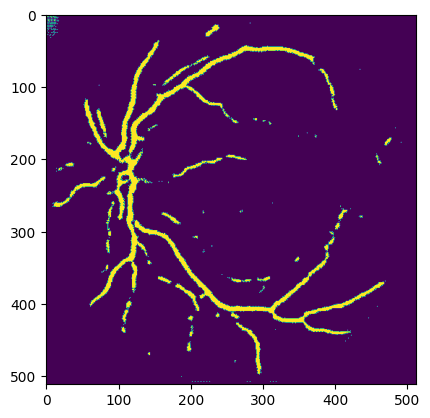

In [33]:
threshold = 0.5
model.eval()
with torch.no_grad():
    for image in images_test:
        filename = os.path.basename(image)
        #cropped_image = crop_image(np.array(Image.open(image)), 20, 40)
        #image = Image.fromarray(cropped_image)
        image = Image.open(image)
        orig_image = image
        image = image.resize((512, 512), resample=Image.NEAREST)
        image = image.convert('L')
        image = transform(image)
        #image = image/255
        image = image.unsqueeze(0)

        image = image.to(device) 
        output = model(image)

        output = output.detach().cpu().numpy()[0]
        output = (output > threshold)
        print(output.shape)
        output = np.transpose(output, (1, 2, 0))
        
        plt.imshow(output)
        
        break
        
        # output_dict = {"mask": output}
        # savemat(test_results_folder + "\/" + filename.strip(".png") + ".mat", output_dict)

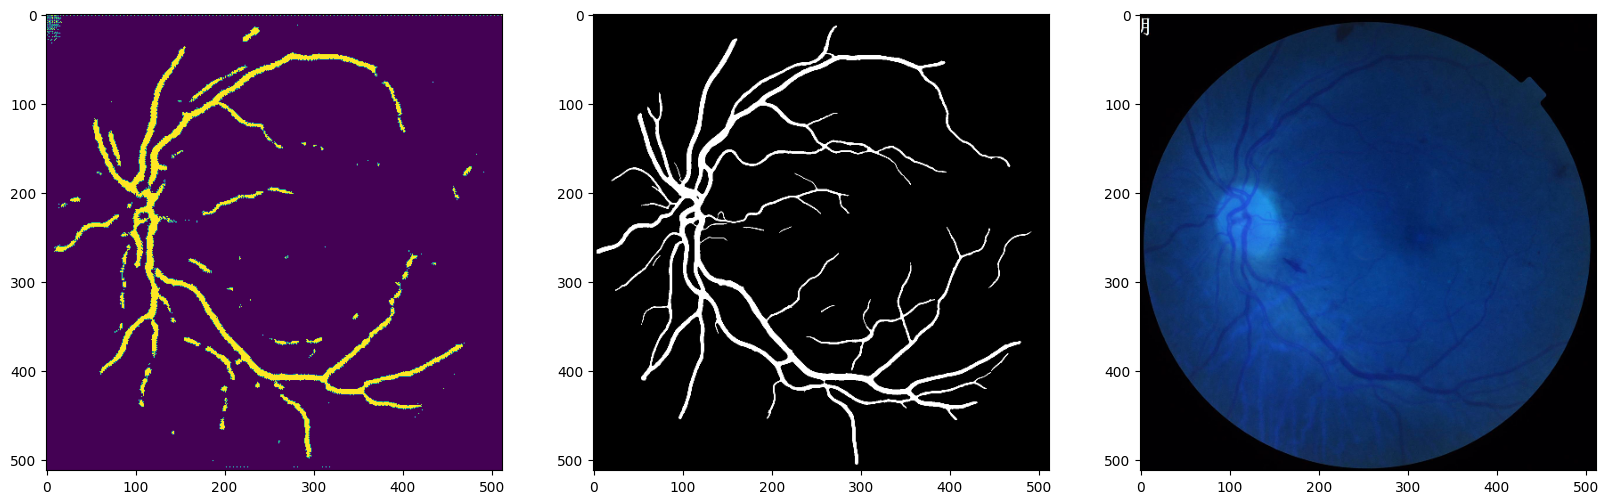

In [37]:
num = 615
img = cv2.imread(images_test[0])
img = cv2.resize(img, (512, 512))
result = output
gt = cv2.imread(images_test_gt[0])
gt = cv2.resize(gt, (512, 512))
# gt[gt == 2] = 1
# gt[gt == 1] = 255
plt.figure(figsize=(20,200))
plt.subplot(1,3,1)
plt.imshow(result)
plt.subplot(1,3,2)
plt.imshow(gt)
plt.subplot(1,3,3)
plt.imshow(img)

In [28]:
output.shape

(512, 512, 1)

In [29]:
img.shape

(2048, 2048, 3)

In [32]:
gt.shape

(2048, 2048, 3)